## Task 1: Preprocess dataset

In [1]:
from datasets import load_dataset
from matplotlib import pyplot as plt

# Load GoEmotions dataset
dataset = load_dataset("google-research-datasets/go_emotions")

print(dataset['train'])

Dataset({
    features: ['text', 'labels', 'id'],
    num_rows: 43410
})


In [2]:
def filter_single_label(example):
    return len(example['labels']) == 1

# Apply filtering
train_data = dataset['train'].filter(filter_single_label)
val_data = dataset['validation'].filter(filter_single_label)
test_data = dataset['test'].filter(filter_single_label)


For Baseline Models (SR, RF, XGBoost):Use TfidfVectorizer from scikit-learn

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_data['text'])
X_val = vectorizer.transform(val_data['text'])
X_test = vectorizer.transform(test_data['text'])

y_train = train_data['labels']
y_val = val_data['labels']
y_test = test_data['labels']


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Example: Random Forest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Validate and Test
y_pred = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))


For LLM (HuggingFace Transformers): Use a tokenizer from the transformers library

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_data(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_encodings = train_data.map(tokenize_data, batched=True)
val_encodings = val_data.map(tokenize_data, batched=True)
test_encodings = test_data.map(tokenize_data, batched=True)

In [12]:
print(train_encodings)

Dataset({
    features: ['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36308
})


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_data['labels'])
)

val_dataset = TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_data['labels'])
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_data['labels'])
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [7]:
from transformers import AutoTokenizer, AutoModel

# Define the path to save the model
save_path = "./pretrained_model"

# Download and save the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", cache_dir=save_path)
base_model = AutoModel.from_pretrained("bert-base-uncased", cache_dir=save_path)

# Verify the save path
print(f"Model and tokenizer saved at: {save_path}")


Model and tokenizer saved at: ./pretrained_model


In [ ]:

import torch.nn as nn
class CustomBertModel(nn.Module):
    def __init__(self, base_model, num_labels):
        super().__init__()
        self.bert = base_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(base_model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, label=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if label is not None:
            criterion = nn.CrossEntropyLoss()
            loss = criterion(logits, label)

        return {'loss':loss, "logits":logits} if loss is not None else {'logits':logits}
    def save_pretrained(self, save_directory):
        # Save tokenizer and model to the specified directory
        torch.save(self.state_dict(), f"{save_directory}/pytorch_model.bin")

In [ ]:
num_labels =  28
model = CustomBertModel(base_model,num_labels)


In [ ]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

# Define hyperparameters
learning_rate = 5e-5
epochs = 3
batch_size = 8
# Move model to GPU if available
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
# Total training steps (for learning rate scheduler)
num_training_steps = len(train_loader) * epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)
# Loss function
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(epochs):

    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    train_loss=0
    for batch in tqdm(train_loader,desc='training'):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids,attention_mask=attention_mask)
        logits = outputs['logits']
        labels = labels.squeeze(-1) 
        # compute loss
        loss = criterion(logits, labels)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Training loss: {avg_train_loss:.4f}")
        
    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            # Forward
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            logits = outputs["logits"]
            labels = labels.squeeze(-1) 
            # Compute loss
            loss = criterion(logits, labels)
            val_loss += loss.item()

            # Compute accuracy
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f"Validation loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")


Epoch 1/3


training: 100%|██████████| 2270/2270 [04:48<00:00,  7.86it/s]


Training loss: 1.5494


Validation: 100%|██████████| 285/285 [00:10<00:00, 27.52it/s]


Validation loss: 1.2559, Accuracy: 0.6223
Epoch 2/3


training: 100%|██████████| 2270/2270 [04:45<00:00,  7.95it/s]


Training loss: 1.0711


Validation: 100%|██████████| 285/285 [00:10<00:00, 27.49it/s]


Validation loss: 1.2452, Accuracy: 0.6242
Epoch 3/3


training: 100%|██████████| 2270/2270 [04:45<00:00,  7.95it/s]


Training loss: 0.7063


Validation: 100%|██████████| 285/285 [00:10<00:00, 27.48it/s]

Validation loss: 1.3452, Accuracy: 0.6209


Analyzing attention patterns...

Analyzing Correct Predictions:

Text: it ' s wonderful because it ' s awful. at not with.
True Label: 0


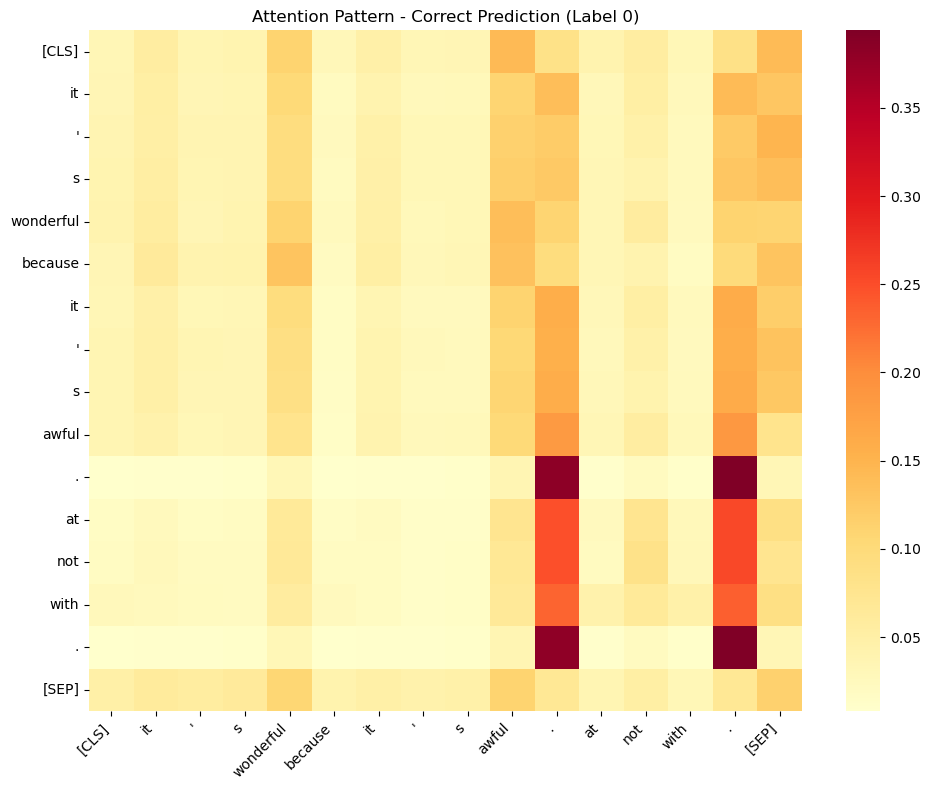


Text: i didn ' t know that, thank you for teaching me something today!
True Label: 15


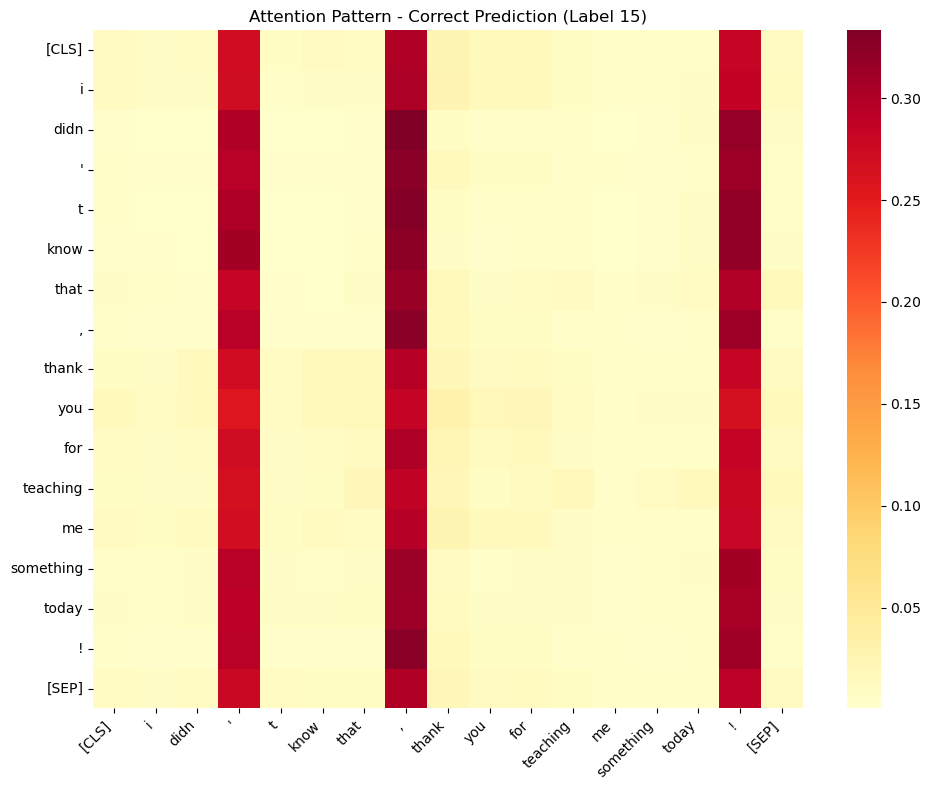


Text: they got bored from haunting earth for thousands of years and ultimately moved on to the afterlife.
True Label: 27


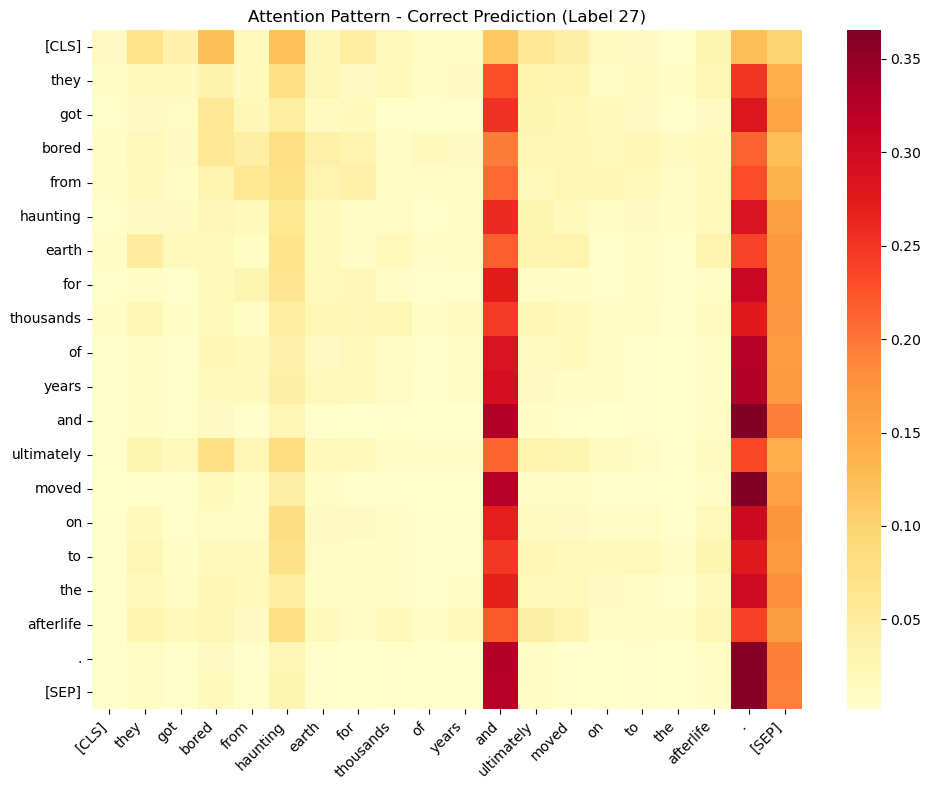


Analyzing Incorrect Predictions:

Text: i ’ m really sorry about your situation : ( although i love the names sapphira, cirilla, and scarlett!
True Label: 25, Predicted Label: 18


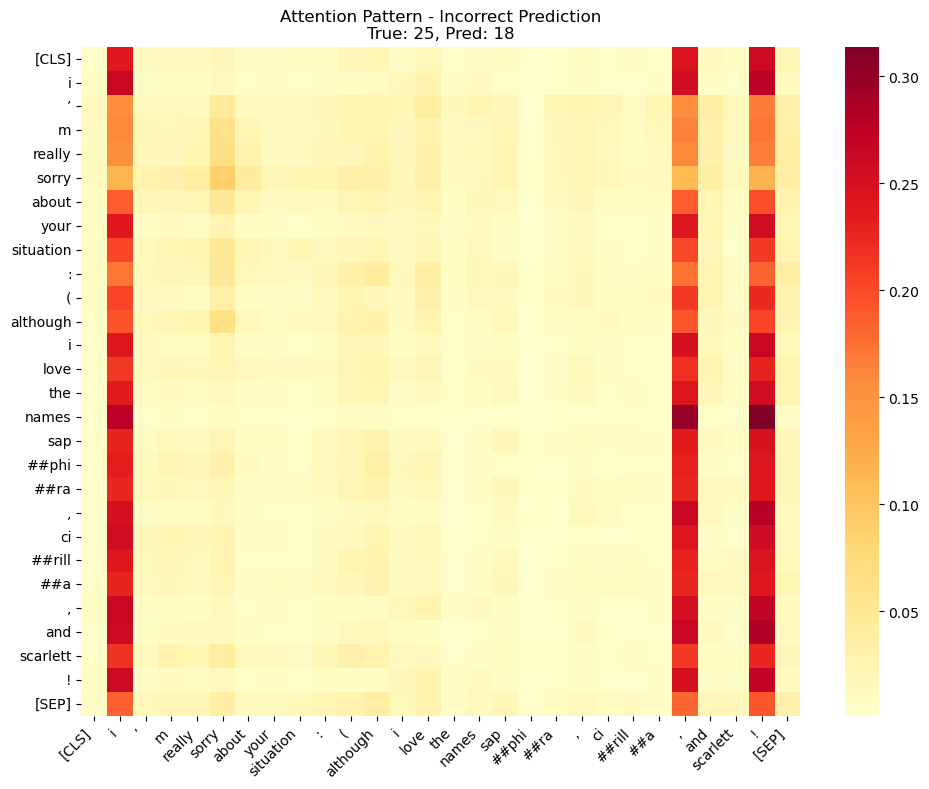


Text: kings fan here, good luck to you guys! will be an interesting game to watch!
True Label: 13, Predicted Label: 20


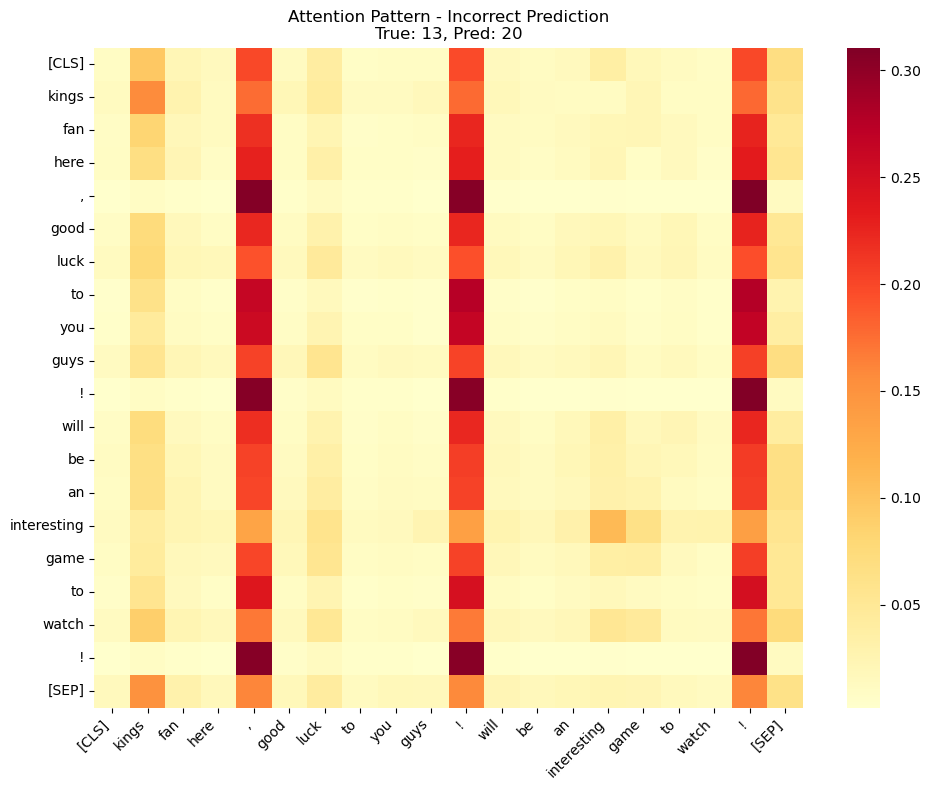


Text: the thought of shooting anything at asylum seekers is appalling.
True Label: 14, Predicted Label: 11


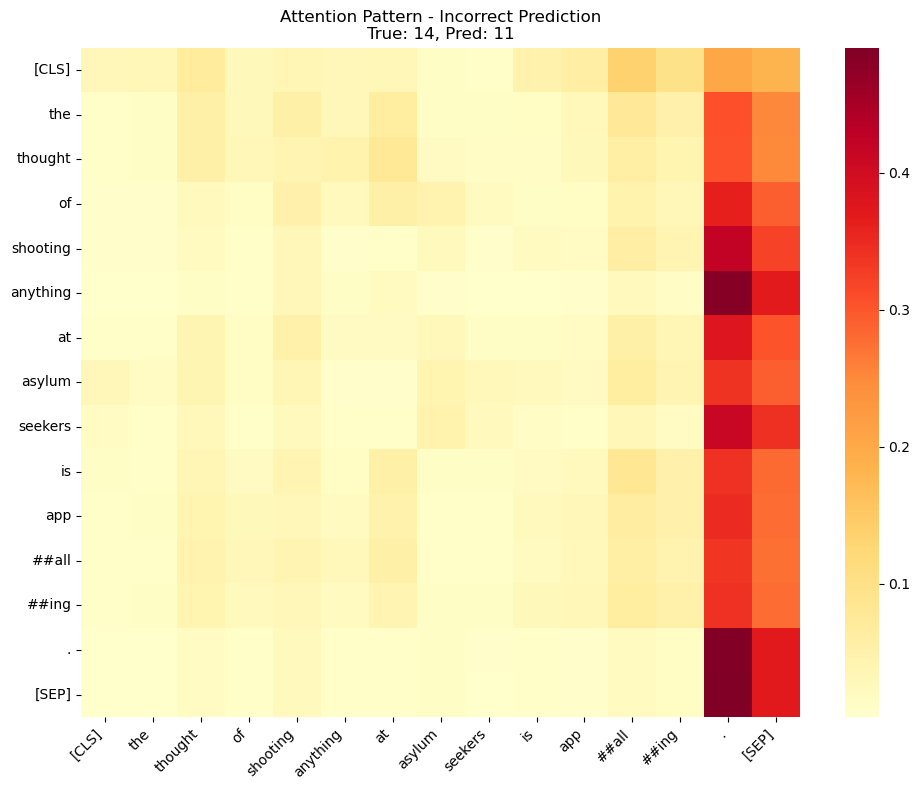

In [13]:
# After the imports at the top, add:
import numpy as np
import seaborn as sns
from bertviz import head_view
import matplotlib.pyplot as plt

def get_attention_weights(model, tokenizer, text, layer_num=11, head_num=0):
    """
    Extract attention weights from a specific layer and head
    Args:
        model: BERT model
        tokenizer: BERT tokenizer
        text: Input text
        layer_num: Which transformer layer to examine (0-11 for BERT-base)
        head_num: Which attention head to examine (0-11 for BERT-base)
    Returns:
        tokens: List of tokens
        attention_weights: Attention weight matrix
    """
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", add_special_tokens=True)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    
    # Get model outputs with output_attentions=True
    with torch.no_grad():
        outputs = model.bert(input_ids=input_ids, 
                           attention_mask=attention_mask,
                           output_attentions=True)
    
    # Get attention weights from specified layer and head
    attention = outputs.attentions[layer_num][0, head_num].cpu().numpy()
    
    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    return tokens, attention

def plot_attention_heatmap(tokens, attention_weights, title="Attention Weights"):
    """
    Plot attention weights as a heatmap
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, 
                xticklabels=tokens,
                yticklabels=tokens,
                cmap='YlOrRd')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Add this after your model evaluation to analyze some examples:
def analyze_predictions(model, tokenizer, test_loader, num_examples=5):
    """
    Analyze attention patterns for correct and incorrect predictions
    """
    model.eval()
    correct_examples = []
    incorrect_examples = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs['logits'], dim=1)
            
            for i in range(len(predictions)):
                text = tokenizer.decode(input_ids[i], skip_special_tokens=True)
                if predictions[i] == labels[i]:
                    correct_examples.append((text, labels[i].item()))
                else:
                    incorrect_examples.append((text, labels[i].item(), predictions[i].item()))
                
                if len(correct_examples) >= num_examples and len(incorrect_examples) >= num_examples:
                    break
                    
    # Analyze correct predictions
    print("\nAnalyzing Correct Predictions:")
    for text, label in correct_examples[:num_examples]:
        print(f"\nText: {text}")
        print(f"True Label: {label}")
        tokens, attention = get_attention_weights(model, tokenizer, text)
        plot_attention_heatmap(tokens, attention, f"Attention Pattern - Correct Prediction (Label {label})")
    
    # Analyze incorrect predictions
    print("\nAnalyzing Incorrect Predictions:")
    for text, true_label, pred_label in incorrect_examples[:num_examples]:
        print(f"\nText: {text}")
        print(f"True Label: {true_label}, Predicted Label: {pred_label}")
        tokens, attention = get_attention_weights(model, tokenizer, text)
        plot_attention_heatmap(tokens, attention, 
                             f"Attention Pattern - Incorrect Prediction\nTrue: {true_label}, Pred: {pred_label}")

# Add this after your model training:
print("Analyzing attention patterns...")
analyze_predictions(model, tokenizer, test_loader, num_examples=3)

## Naive Bayes

### Data processing

In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_parquet("hf://datasets/google-research-datasets/go_emotions/raw/train-00000-of-00001.parquet")
labels = df.columns[9:]
df1 = df[df[labels].sum(axis=1) == 1]
comments = df1['text'].tolist()
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(comments)
y = df1[labels].values
y = np.argmax(y, axis=1)
# Note X must be a sparse matrix. This is because the session crashes otherwise
# y is integer encoded not one hot encoded

### Naive Bayes implementation

In [ ]:
class NaiveBayes:
    def __init__(self):
        self.px = None
        self.py = None

    def fit(self, X, y):
        # Shape of X is (N, L) where L is the length of the embedding vectors, X is a sparse matrix
        # Shape of y is (N,) where N is sample size

        self.X = X    # Bag of words representation
        self.y = y    # Integer labeled
        n = X.shape[0]
        C = len(np.unique(y))

        # Compute class priors (py)
        for c in range(C):
            self.py = np.bincount(y)[c] / n

        # Initialize px as a list to store likelihoods
        self.px = []

        for c in range(C):
            # Select samples where the class is c
            y_c = (y == c)  # Binary mask for samples with class c
            X_c = X[y_c == 1]  # Extract samples where class is c

            # Compute the likelihood P(x_i | y_c) for each feature
            px_c = (X_c.sum(axis=0) + 1) / (y_c.sum() + X.shape[1])
            px_c = np.asarray(px_c).ravel()  # Ensure it's a dense 1D array

            self.px.append(px_c)  # Add the likelihoods for class c

        # Convert px to numpy array of shape (C, L)
        self.px = np.array(self.px)

    def predict(self, X):
        # Compute the log of the posterior probabilities for each class
        log_py = np.log(self.py)  # Log of class priors
        log_px = np.log(self.px)  # Log of feature likelihoods

        # Compute log-posterior for each class (N samples, C classes)
        log_posterior = X.dot(log_px.T) + log_py  # `X` remains sparse

        # Return the class with the highest posterior probability for each sample
        return np.argmax(log_posterior, axis=1)

    def evaluate_acc(self, Y, Yh):
        return np.mean(Y == Yh)
    
model = NaiveBayes()
model.fit(X, y)
Yh = model.predict(X)
evaluate_acc = model.evaluate_acc(y, Yh)
print("evaluate_accuracy =",evaluate_acc)
class_counts = np.bincount(y)
print("Class counts:", class_counts)

baseline_accuracy = np.max(class_counts) / len(y)
print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

evaluate_accuracy = 0.41981725061110464
Class counts: [10531  6130  5202  8342 11259  3523  4938  5885  2147  4706  7686  2914
  1433  3020  1778  7075   351  4329  4957   796  4519   690  4714   788
  1510  3827  3472 55298]
Baseline Accuracy: 0.32
